もっとも基本的な softmax 識別の前段にフィルタ層をつけてみる

# 16フィルタによるMNISTの手書き数字認識

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import seaborn as sns
import tensorflow as tf
import mytfext
%matplotlib inline

※ tensorflow にはMNISTのサンプルデータをダウンロードするためのモジュールが備わっている

In [13]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


※ Windowsの場合、データはC:\tmp\dataに保存される

# モデルの作成

In [14]:
# モデルの作成
np.random.seed(19601228)
tf.set_random_seed(19601228)

class NN:
    def __init__(self, num_filters, num_units,learning_rate=0.001):
        with tf.Graph().as_default():
            self.model(num_filters,num_units,learning_rate)
            self.session()
    
    def model(self, num_filters, num_units,learning_rate=0.001):
        with tf.name_scope("filters"):
            img = tf.placeholder(tf.float32,[None,784])
            tf_image = tf.reshape(img, [-1,28,28,1])
            
            W_conv = tf.Variable(tf.truncated_normal([5,5,1,num_filters],stddev=0.1))
            h_conv = tf.nn.conv2d(tf_image, W_conv, strides=[1,1,1,1], padding="SAME")
            h_pool = tf.nn.max_pool(h_conv, ksize=[1,4,4,1],strides=[1,2,2,1], padding="SAME")
            
        with tf.name_scope("softmax"):
            num_Punits = 14*14*num_filters
            h_pool_fl = tf.reshape(h_pool, [-1,num_Punits])
            wOut = tf.Variable(tf.zeros([num_Punits, 10]))
            bOut = tf.Variable(tf.zeros([10]))
            out = tf.nn.softmax(tf.matmul(h_pool_fl,wOut)+bOut)
            
        with tf.name_scope("Optimizer") as scope:
            ideal = tf.placeholder(tf.float32, [None, 10], name="ideal")
            loss = -tf.reduce_sum(ideal*tf.log(out), name="loss")
            tf.summary.scalar("cross_entropy", loss)
            # train_step = tf.train.GradientDescentOptimizer(0.00002).minimize(loss)
            train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
        
        with tf.name_scope("Evaluator") as scope:
            correct_prediction = tf.equal(tf.argmax(out,1),tf.argmax(ideal,1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")
            tf.summary.scalar("accuracy", accuracy)
        
        self.img, self.ideal, self.out = img, ideal, out
        self.train_step = train_step
        self.loss, self.accuracy = loss, accuracy
        self.W_conv = W_conv
        
    def session(self):
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())
        # sess.run(tf.local_variables_initializer())
        summary = tf.summary.merge_all()
        writer = tf.summary.FileWriter("log7", sess.graph)
                               
        self.sess = sess
        self.summary = summary
        self.writer = writer

# セッションの開始

In [17]:
nn = NN(16,64,learning_rate=0.0002)

In [18]:
times = 0
for _ in range(2000):
    times += 1
    batch_xs,batch_ts = mnist.train.next_batch(100)
    nn.sess.run(nn.train_step, feed_dict={nn.img:batch_xs, nn.ideal:batch_ts})
    if times % 100 == 0:
        loss_val, acc_val = nn.sess.run([nn.loss,nn.accuracy],
                feed_dict={nn.img:mnist.test.images, nn.ideal:mnist.test.labels})
        print("Step: {0:d}, Loss: {1:f}, Accuracy: {2:f}".format(times, loss_val, acc_val))

Step: 100, Loss: 8934.921875, Accuracy: 0.828700
Step: 200, Loss: 5025.769043, Accuracy: 0.883000
Step: 300, Loss: 3731.952393, Accuracy: 0.905400
Step: 400, Loss: 3110.806885, Accuracy: 0.920200
Step: 500, Loss: 2675.024902, Accuracy: 0.929300
Step: 600, Loss: 2321.418457, Accuracy: 0.941000
Step: 700, Loss: 2095.717285, Accuracy: 0.943100
Step: 800, Loss: 1956.653076, Accuracy: 0.948700
Step: 900, Loss: 1788.742065, Accuracy: 0.952200
Step: 1000, Loss: 1625.733032, Accuracy: 0.955100
Step: 1100, Loss: 1521.225098, Accuracy: 0.959400
Step: 1200, Loss: 1430.542603, Accuracy: 0.960800
Step: 1300, Loss: 1366.744141, Accuracy: 0.961500
Step: 1400, Loss: 1283.298218, Accuracy: 0.964900
Step: 1500, Loss: 1190.012451, Accuracy: 0.968000
Step: 1600, Loss: 1167.690063, Accuracy: 0.966800
Step: 1700, Loss: 1097.454346, Accuracy: 0.970100
Step: 1800, Loss: 1050.390503, Accuracy: 0.970100
Step: 1900, Loss: 1054.233276, Accuracy: 0.971200
Step: 2000, Loss: 1029.188721, Accuracy: 0.971100


# 学習結果を用いて文字認識してみる

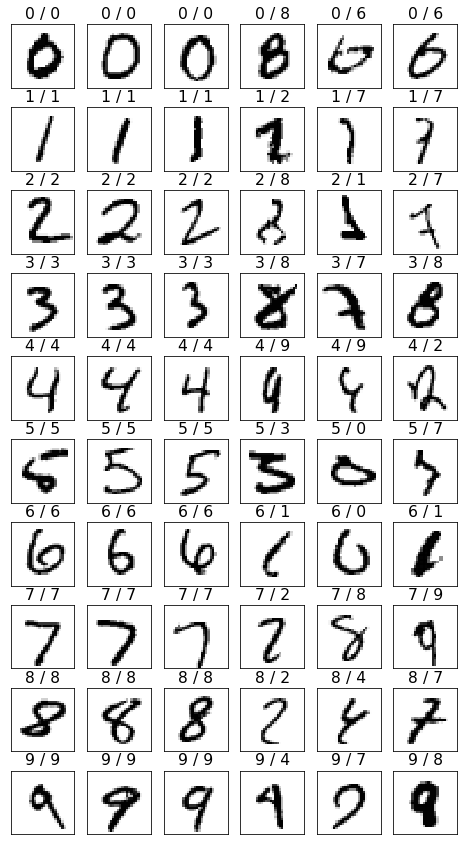

In [7]:
plt.figure(figsize=(8,15))
def plotchr(image,label1,label2, i):
    sns.set_context("talk")
    plt.subplot(10,6,i)
    plt.xticks([])
    plt.yticks([])
    plt.title("%d / %d" % (np.argmax(label1),np.argmax(label2)))
    plt.imshow(image,cmap=plt.cm.gray_r)
    
images, labels = mnist.test.images, mnist.test.labels
p_val = nn.sess.run(nn.out, feed_dict={nn.img:images, nn.ideal:labels})

# 0～9 と判定されたものについて、それぞれ正の例を３つ、負の例を３つ表示する
picnumber = 0
for i in range(10):
    c = 0
    for (image, label, pred) in zip(images, labels, p_val):
        prediction,actual = np.argmax(pred), np.argmax(label)
        if prediction != i:  # 
            continue
        if(c<3 and i == actual) or (c>=3 and i != actual):
            picnumber += 1
            plotchr(image.reshape((28,28)),pred,label,picnumber)
            c += 1
            if c > 5:
                break
            

# フィルタを表示

In [9]:
def showFilter():
    fig = plt.figure(figsize=(5,5))
    filters = nn.sess.run(nn.W_conv)
    for i in range(4):
        for j in range(4):
            fig.add_subplot(4,4,4*i+j+1)
            sns.heatmap(filters[:,:,0,i*4+j],yticklabels=[],xticklabels=[],cmap=plt.cm.bwr,cbar=False,annot=False,square=True)
    fig2 = plt.figure()
    sns.heatmap(filters[:,:,0,0],yticklabels=[],xticklabels=[],cmap=plt.cm.bwr,cbar=True,annot=False,square=True)

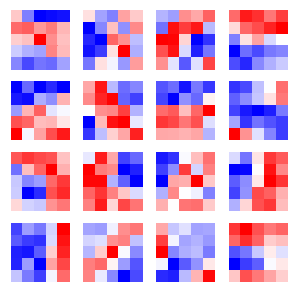

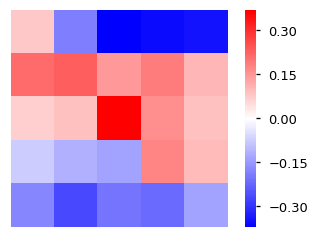

In [10]:
showFilter()